# Correlation analysis between Google News articles and stock prices

## Setup

###### Load dependency libraries

In [1]:
from pygooglenews import GoogleNews
from bs4 import BeautifulSoup
from langdetect import detect
import numpy as np 
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display, DisplayObject
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
import pandas as pd
import time, calendar
import os

###### Get interval-level stock price data

In [23]:
def get_stock_data_by_interval(symbol, start_datetime, end_datetime, interval='1m'):
    # Interval argument examples : '1m', '1h', '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
    # Start and end datetime format example : '2000-01-01 12:34:00'
    start_timestamp = calendar.timegm(time.strptime(start_datetime, '%Y-%m-%d %H:%M:%S')) - 86400
    end_timestamp = calendar.timegm(time.strptime(end_datetime, '%Y-%m-%d %H:%M:%S')) + 86400
    
    url = f'https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?interval={interval}&period1={start_timestamp}&period2={end_timestamp}'
    result = requests.get(url)
    
    data = result.json()
    body = data['chart']['result'][0]
    price_data_body = body['indicators']['quote'][0]
    
    df = pd.DataFrame()
    df['Datetime'] = body['timestamp']
    df['Datetime'] = pd.to_datetime(df['Datetime'],unit='s')
    df['high'] = price_data_body['high']
    df['low'] = price_data_body['low']
    df['volume'] = price_data_body['volume']
    df['open'] = price_data_body['open']
    df['close'] = price_data_body['close']
    
    return df

# Function signature examples
# Get minute-level stock price information within 10 minute timeframe
# display(get_stock_data_by_interval('MRNA', '2021-02-09 14:29:00', '2021-02-09 14:41:00'))

# Get hourly stock price information within 24h timeframe
# display(get_stock_data_by_interval('MRNA', '2021-02-09 21:00:00', '2021-02-10 21:00:00', '1h'))

###### Get combined average sentiment score between TextBlob and Vader

In [3]:
# Sentiment score from TextBlob
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Sentiment score from Vader
def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs['compound']

def get_combined_sentiment_score(text):
    return (get_vader_sentiment(text) + get_textblob_sentiment(text)) / 2

###### Get articles about single stock for the last number of days

In [4]:
def remove_html_tags(html):
    return BeautifulSoup(html).get_text()

def get_news_dataframe(ticker, query, timeframe_in_days):
    end_date = pd.to_datetime('today').date()
    start_date = end_date - timedelta(days=timeframe_in_days)  
    delta = timedelta(days=1)
    
    dates = []
    
    while start_date <= end_date:
        dates.append(str(start_date))
        start_date += delta
        
    dates = np.array(dates)
    results = []
    
    gn = GoogleNews()
    
    for i in range(len(dates)-1):
        results.append(gn.search(query, from_=dates[i], to_=dates[i+1]))
        
    
    results = np.array(results)
    data = []
    
    
    for result in results:
        for entry in result['entries']:
            
            data.append({
                'title': entry['title'],
                'summary': entry['summary'],
                'published': entry['published'],
                'link': entry['link'],
                'source': entry['source']['title'],
                'ticker': ticker
            })
    
    news_df = pd.DataFrame(data)

    news_df['summary'] = news_df['summary'].apply(lambda x : remove_html_tags(x))
    news_df['sentiment_score'] = news_df['summary'].apply(lambda x : get_combined_sentiment_score(x))
    news_df['published'] = news_df['published'].apply(lambda x : datetime.strptime(x, "%a, %d %b %Y %H:%M:%S %Z"))
    news_df['language'] = news_df['summary'].apply(lambda x : detect(x))
    
    news_df = news_df.drop_duplicates(subset=['title', 'published', 'source'], keep='first')
    
    return news_df


# # Function signature example
# Get articles about MRNA stock for the last 20 days
# get_news_dataframe(ticker='MRNA', query='MRNA AND Moderna', timeframe_in_days=20)

###### Get news dataframee about specific stocks we will be using throughout this correlation analysis notebook

**Stocks:**  
1. MRNA (Moderna)
2. PENN (Penn National Gaming)
3. NVDA (Nvidia)
4. PDD (Pinduoduo)
5. AZO (AutoZone)
6. ETSY (Etsy Inc)
7. DOCU (DocuSign)
8. VRTX (Vertex Pharmaceuticals)
9. EDIT (Editas Medicine)

In [5]:
mrna_news_df = get_news_dataframe(ticker='MRNA', query='MRNA AND Moderna', timeframe_in_days=30)
penn_news_df = get_news_dataframe(ticker='PENN', query='PENN AND "Penn National Gaming"', timeframe_in_days=30)
nvda_news_df = get_news_dataframe(ticker='NVDA', query='NVDA AND Nvidia', timeframe_in_days=30)
pdd_news_df = get_news_dataframe(ticker='PDD', query='PDD AND Pinduoduo', timeframe_in_days=30)
azo_news_df = get_news_dataframe(ticker='AZO', query='AZO AND AutoZone', timeframe_in_days=30)
etsy_news_df = get_news_dataframe(ticker='ETSY', query='ETSY AND "Etsy Inc"', timeframe_in_days=30)
docu_news_df = get_news_dataframe(ticker='DOCU', query='DOCU AND DocuSign', timeframe_in_days=30)
vrtx_news_df = get_news_dataframe(ticker='VRTX', query='VRTX AND "Vertex Pharmaceuticals"', timeframe_in_days=30)
edit_news_df = get_news_dataframe(ticker='EDIT', query='EDIT AND "Editas Medicine"', timeframe_in_days=30)

In [6]:
mrna_news_df

,title,summary,published,link,source,ticker,sentiment_score,language
0,This Is the Best News Yet for Moderna's COVID ...,This Is the Best News Yet for Moderna's COVID ...,2021-01-17 08:00:00,https://www.fool.com/investing/2021/01/17/this...,The Motley Fool,MRNA,0.559100,en
1,COVID Vaccines Open Door for Cancer Treatments...,COVID Vaccines Open Door for Cancer Treatments...,2021-01-17 08:00:00,https://www.voanews.com/science-health/covid-v...,Voice of America,MRNA,-0.329850,en
2,Swiss to get Moderna vaccine in tranches until...,Swiss to get Moderna vaccine in tranches until...,2021-01-17 08:00:00,https://finance.yahoo.com/news/swiss-moderna-v...,Yahoo Finance,MRNA,0.000000,en
3,The Pfizer vaccine may not be the best choice ...,The Pfizer vaccine may not be the best choice ...,2021-01-18 08:00:00,https://theconversation.com/the-pfizer-vaccine...,The Conversation AU,MRNA,0.003800,en
4,Delaying second COVID-19 vaccine doses will ma...,Delaying second COVID-19 vaccine doses will ma...,2021-01-17 08:00:00,https://www.marinij.com/2021/01/17/delaying-se...,Marin Independent Journal,MRNA,-0.195950,en
...,...,...,...,...,...,...,...,...
2102,"UPDATE: City, county schools closed Tuesday - ...","UPDATE: City, county schools closed Tuesday Y...",2021-02-15 23:17:00,https://news.yahoo.com/city-county-schools-clo...,Yahoo News,MRNA,-0.050000,en
2103,Scrip Asks…What Does 2021 Hold For Biopharma? ...,Scrip Asks…What Does 2021 Hold For Biopharma? ...,2021-02-15 18:57:05,https://scrip.pharmaintelligence.informa.com/S...,Scrip,MRNA,0.000000,en
2104,Florida Emergency Management Director Jared Mo...,Florida Emergency Management Director Jared Mo...,2021-02-16 00:44:37,https://news.yahoo.com/florida-emergency-manag...,Yahoo News,MRNA,-0.268678,en
2105,France fines Google 1.1 million euros over hot...,France fines Google 1.1 million euros over hot...,2021-02-15 09:48:00,https://news.yahoo.com/france-fines-google-1-1...,Yahoo News,MRNA,0.000000,en


In [7]:
news_df_list = [
    mrna_news_df,
    penn_news_df,
    nvda_news_df,
    pdd_news_df,
    azo_news_df,
    etsy_news_df,
    docu_news_df,
    vrtx_news_df,
    edit_news_df
]

## 1. Correlation between number of articles (per day) and stock price move (close - open)

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

<AxesSubplot:xlabel='source', ylabel='price_move'>

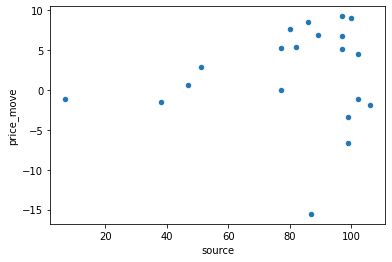

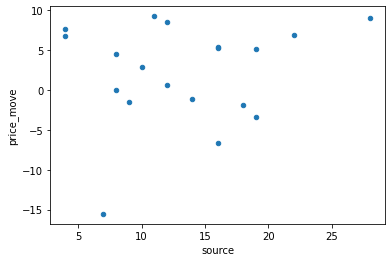

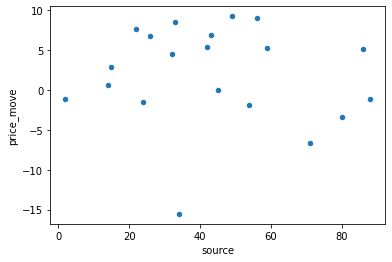

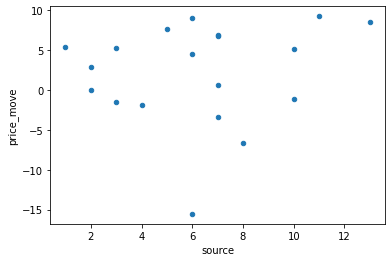

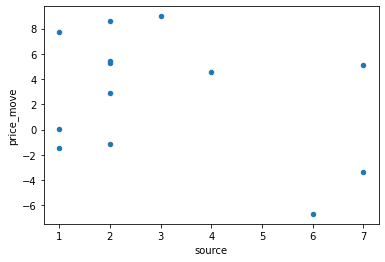

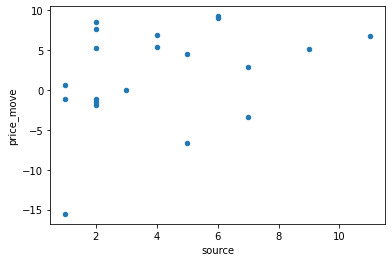

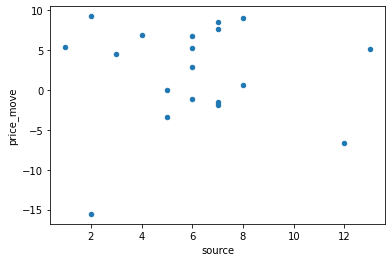

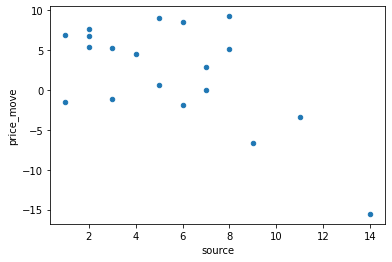

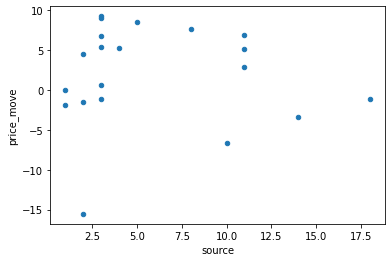

In [52]:
for news_df in news_df_list:
    df = pd.DataFrame()
    df['ticker'] = news_df['ticker']
    # df['sentiment_score'] = news_df['sentiment_score']
    df['date'] = news_df['published'].dt.normalize()
    df['source'] = news_df['source']
    
    df = df.groupby(['date', 'ticker']).agg('count').reset_index().set_index('date')
    start_date = df.index[0].strftime("%Y-%m-%d %H:%M:%S")
    end_date = df.index[-1].strftime("%Y-%m-%d %H:%M:%S")
    
    price_df = get_stock_data_by_interval(symbol, start_date, end_date, '1d')
    price_df['Datetime'] = price_df['Datetime'].dt.normalize()
    
    price_df = price_df.set_index('Datetime')
    joined_df = df.join(price_df)
    
    joined_df = joined_df.loc[joined_df['high'].notnull()]
    joined_df['price_move'] = joined_df['close'] - joined_df['open']
    display(joined_df.plot.scatter(x='source', y='price_move'))